### Generation des images des chiffres de 1 a 31

In [29]:
import os
import csv
import random
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageOps

# === PARAMÈTRES ===
font = ImageFont.truetype("arial.ttf", 36)  # Assure-toi que la police est installée
output_dir = "dataset_chiffres_1_31_final"
os.makedirs(output_dir, exist_ok=True)
labels_file = os.path.join(output_dir, "labels.csv")

# === GÉNÉRATION DES IMAGES + LABELS ===
with open(labels_file, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "label"])  # Header

    for label in range(1, 32):  # De 1 à 31 inclus
        for i in range(1500):
            img = Image.new("L", (64, 64), color=255)  # Image en niveaux de gris
            draw = ImageDraw.Draw(img)
            text = str(label)

            # Position aléatoire dans l'image
            x_offset = random.randint(5, 15)
            y_offset = random.randint(5, 15)

            draw.text((x_offset, y_offset), text, font=font, fill=0)

            # Rotation aléatoire
            angle = random.randint(-20, 20)
            img = img.rotate(angle, fillcolor=255)

            # Flip aléatoire
            if random.random() < 0.3:
                img = ImageOps.mirror(img)
            if random.random() < 0.3:
                img = ImageOps.flip(img)

            # Luminosité aléatoire
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.8, 1.2))

            # Sauvegarde de l'image
            filename = f"{label}_{i}.png"
            filepath = os.path.join(output_dir, filename)
            img.save(filepath)

            # Sauvegarde du label dans le CSV
            writer.writerow([filename, label])

print(f"✅ Génération terminée : {31 * 1500} images dans '{output_dir}'")


✅ Génération terminée : 46500 images dans 'dataset_chiffres_1_31_final'


### Création du model de reconnaissance des chiffres de 1 à 31

In [9]:
import os
import csv
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# ===============================
# 1. Définition du modèle CNN
# ===============================
class ChiffreCNN(nn.Module):
    def __init__(self):
        super(ChiffreCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 31)  # classes 1 à 31

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64 → 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 32x32 → 16x16
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===============================
# 2. Dataset personnalisé
# ===============================
class ChiffreDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_path).convert('L')
        label = int(self.labels_df.iloc[idx, 1]) - 1  # pour avoir des labels 0–30
        if self.transform:
            image = self.transform(image)
        return image, label
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChiffreCNN().to(device)

In [ ]:

# ===============================
# 3. Préparation des données
# ===============================
img_dir = "dataset_chiffres_1_31_final"
csv_file = os.path.join(img_dir, "labels.csv")

# Split train/val
df = pd.read_csv(csv_file)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_csv = "train_labels.csv"
val_csv = "val_labels.csv"
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

# Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ChiffreDataset(train_csv, img_dir, transform)
val_dataset = ChiffreDataset(val_csv, img_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ===============================
# 4. Entraînement du modèle
# ===============================

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total

    print(f"📘 Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_chiffre_cnn.pth")
        print("✅ Nouveau meilleur modèle sauvegardé")

print("🏁 Entraînement terminé.")


📘 Epoch 1/10 | Train Acc: 71.08% | Val Acc: 93.49%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 2/10 | Train Acc: 95.65% | Val Acc: 97.48%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 3/10 | Train Acc: 97.69% | Val Acc: 98.61%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 4/10 | Train Acc: 98.34% | Val Acc: 98.70%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 5/10 | Train Acc: 98.73% | Val Acc: 98.97%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 6/10 | Train Acc: 98.83% | Val Acc: 99.00%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 7/10 | Train Acc: 98.98% | Val Acc: 99.45%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 8/10 | Train Acc: 99.14% | Val Acc: 99.16%
📘 Epoch 9/10 | Train Acc: 99.21% | Val Acc: 98.67%
📘 Epoch 10/10 | Train Acc: 99.30% | Val Acc: 99.56%
✅ Nouveau meilleur modèle sauvegardé
🏁 Entraînement terminé.


In [ ]:
"data/clean_image/30mm_BonW_7.jpg"

### Extraction  des ROIS en vue de test : 

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def extract_and_display_regions(rectangles, image_path, cols=5, figsize=(15, 20)):
    """
    Extrait et affiche les régions d'intérêt à partir d'une liste de rectangles
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - cols: Nombre de colonnes pour l'affichage (défaut: 5)
    - figsize: Taille de la figure matplotlib (défaut: (15, 20))
    """
    
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return
    
    # Convertir BGR vers RGB pour matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculer le nombre de lignes nécessaires
    rows = (len(rectangles) + cols - 1) // cols
    
    # Créer la figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(f'Régions extraites - {len(rectangles)} zones détectées', fontsize=16, fontweight='bold')
    
    # S'assurer que axes est toujours un tableau 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Extraire et afficher chaque région
    for i, rect in enumerate(rectangles):
        row = i // cols
        col = i % cols
        
        # Extraire la région
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites de l'image
        x = max(0, x)
        y = max(0, y)
        x_end = min(image_rgb.shape[1], x + w)
        y_end = min(image_rgb.shape[0], y + h)
        
        # Extraire la région d'intérêt
        roi = image_rgb[y:y_end, x:x_end]
        
        # Afficher la région
        ax = axes[row, col]
        ax.imshow(roi)
        ax.set_title(f'ROI {i+1}\n({x},{y}) {w}×{h}', fontsize=10)
        ax.axis('off')
        
        # Afficher les dimensions de la région extraite
        print(f"ROI {i+1:2d}: Position({x:4d},{y:4d}) Taille({w:3d}×{h:3d}) → Extrait({roi.shape[1]:3d}×{roi.shape[0]:3d})")
    
    # Masquer les axes inutilisés
    total_plots = rows * cols
    for i in range(len(rectangles), total_plots):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def save_extracted_rois(rectangles, image_path, output_folder="extracted_rois"):
    """
    Extrait les régions d'intérêt et les sauvegarde dans un dossier
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - output_folder: Nom du dossier de sortie (défaut: "extracted_rois")
    
    Returns:
    - Liste des chemins des fichiers sauvegardés
    """
    
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return []
    
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📁 Dossier '{output_folder}' créé")
    
    # Extraire le nom de base de l'image pour le naming
    #base_name = os.path.splitext(os.path.basename(image_path))[0]
    base_name = "image"
    
    saved_files = []
    
    print(f"💾 Sauvegarde des ROIs dans '{output_folder}'...")
    
    # Extraire et sauvegarder chaque région
    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites de l'image
        x = max(0, x)
        y = max(0, y)
        x_end = min(image.shape[1], x + w)
        y_end = min(image.shape[0], y + h)
        
        # Extraire la région d'intérêt
        roi = image[y:y_end, x:x_end]
        
        # Créer le nom du fichier
        filename = f"{base_name}_roi_{i+1:02d}.jpg"
        filepath = os.path.join(output_folder, filename)
        
        # Sauvegarder l'image
        success = cv2.imwrite(filepath, roi)
        
        if success:
            saved_files.append(filepath)
            print(f"✅ ROI {i+1:2d}: {filename} ({roi.shape[1]}×{roi.shape[0]} pixels)")
        else:
            print(f"❌ Erreur lors de la sauvegarde de ROI {i+1}")
    
    print(f"\n🎉 {len(saved_files)}/{len(rectangles)} ROIs sauvegardées avec succès!")
    print(f"📂 Dossier: {os.path.abspath(output_folder)}")
    
    return saved_files

def extract_display_and_save(rectangles, image_path, output_folder="extracted_rois", cols=5, figsize=(15, 20)):
    """
    Fonction combinée qui affiche ET sauvegarde les ROIs
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - output_folder: Nom du dossier de sortie (défaut: "extracted_rois")
    - cols: Nombre de colonnes pour l'affichage (défaut: 5)
    - figsize: Taille de la figure matplotlib (défaut: (15, 20))
    
    Returns:
    - Tuple (figure_matplotlib, liste_fichiers_sauvegardés)
    """
    
    # Afficher les ROIs
    #fig = extract_and_display_regions(rectangles, image_path, cols, figsize)
    
    # Sauvegarder les ROIs
    saved_files = save_extracted_rois(rectangles, image_path, output_folder)
    
    return saved_files

def extract_regions_as_array(rectangles, image_path):
    """
    Extrait les régions et les retourne comme un tableau numpy
    
    Returns:
    - Liste des régions extraites (images numpy)
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return []
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    regions = []
    
    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites
        x = max(0, x)
        y = max(0, y)
        x_end = min(image_rgb.shape[1], x + w)
        y_end = min(image_rgb.shape[0], y + h)
        
        # Extraire la région
        roi = image_rgb[y:y_end, x:x_end]
        regions.append(roi)
    
    return regions

# ============================================================================
# EXEMPLE D'UTILISATION COMPLET
# ============================================================================

if __name__ == "__main__":
    
    # Vos rectangles détectés
    rectangles = [
        {'x': 2060, 'y': 3366, 'width': 248, 'height': 355},
        {'x': 2358, 'y': 3344, 'width': 259, 'height': 315},
        {'x': 2617, 'y': 3282, 'width': 265, 'height': 309},
        {'x': 2820, 'y': 3152, 'width': 304, 'height': 265},
        {'x': 2967, 'y': 2944, 'width': 343, 'height': 287},
        {'x': 3220, 'y': 2679, 'width': 298, 'height': 316},
        {'x': 3316, 'y': 2409, 'width': 292, 'height': 327},
        {'x': 3361, 'y': 2184, 'width': 337, 'height': 225},
        {'x': 3349, 'y': 1942, 'width': 361, 'height': 191},
        {'x': 3316, 'y': 1610, 'width': 343, 'height': 304},
        {'x': 3265, 'y': 1317, 'width': 304, 'height': 338},
        {'x': 3085, 'y': 1069, 'width': 332, 'height': 349},
        {'x': 2854, 'y': 867, 'width': 355, 'height': 360},
        {'x': 2662, 'y': 686, 'width': 305, 'height': 372},
        {'x': 2409, 'y': 641, 'width': 282, 'height': 355},
        {'x': 2116, 'y': 579, 'width': 327, 'height': 366},
        {'x': 1812, 'y': 613, 'width': 344, 'height': 299},
        {'x': 1548, 'y': 647, 'width': 349, 'height': 321},
        {'x': 1311, 'y': 737, 'width': 316, 'height': 343},
        {'x': 1069, 'y': 945, 'width': 327, 'height': 299},
        {'x': 867, 'y': 1142, 'width': 320, 'height': 333},
        {'x': 731, 'y': 1368, 'width': 321, 'height': 321},
        {'x': 602, 'y': 1621, 'width': 360, 'height': 326},
        {'x': 591, 'y': 1902, 'width': 326, 'height': 338},
        {'x': 579, 'y': 2223, 'width': 361, 'height': 287},
        {'x': 669, 'y': 2505, 'width': 350, 'height': 287},
        {'x': 816, 'y': 2747, 'width': 338, 'height': 259},
        {'x': 1002, 'y': 2938, 'width': 326, 'height': 344},
        {'x': 1232, 'y': 3158, 'width': 304, 'height': 310},
        {'x': 1503, 'y': 3287, 'width': 281, 'height': 288},
        {'x': 1773, 'y': 3299, 'width': 338, 'height': 529}
    ]
    
    # Chemin vers votre image 30mm_BonW_7.jpg
    image_path = "data/clean_image/30mm_BonW_9.jpg"  # Remplacez par le chemin de votre image
    
    print("="*60)
    print("🚀 EXTRACTION ET SAUVEGARDE DES RÉGIONS D'INTÉRÊT")
    print("="*60)
    
    # OPTION 1: Afficher ET sauvegarder (recommandé)
    print("\n📋 Option 1: Affichage + Sauvegarde")
    saved_files = extract_display_and_save(
        rectangles, 
        image_path, 
        output_folder="extracted_rois", 
        cols=6, 
        figsize=(18, 25)
    )
    
    

    
    
    print("\n" + "="*60)
    print("✨ TRAITEMENT TERMINÉ !")
    print("="*60)


🚀 EXTRACTION ET SAUVEGARDE DES RÉGIONS D'INTÉRÊT

📋 Option 1: Affichage + Sauvegarde
💾 Sauvegarde des ROIs dans 'extracted_rois'...
✅ ROI  1: image_roi_01.jpg (248×355 pixels)
✅ ROI  2: image_roi_02.jpg (259×315 pixels)
✅ ROI  3: image_roi_03.jpg (265×309 pixels)
✅ ROI  4: image_roi_04.jpg (304×265 pixels)
✅ ROI  5: image_roi_05.jpg (343×287 pixels)
✅ ROI  6: image_roi_06.jpg (298×316 pixels)
✅ ROI  7: image_roi_07.jpg (292×327 pixels)
✅ ROI  8: image_roi_08.jpg (337×225 pixels)
✅ ROI  9: image_roi_09.jpg (361×191 pixels)
✅ ROI 10: image_roi_10.jpg (343×304 pixels)
✅ ROI 11: image_roi_11.jpg (304×338 pixels)
✅ ROI 12: image_roi_12.jpg (332×349 pixels)
✅ ROI 13: image_roi_13.jpg (355×360 pixels)
✅ ROI 14: image_roi_14.jpg (305×372 pixels)
✅ ROI 15: image_roi_15.jpg (282×355 pixels)
✅ ROI 16: image_roi_16.jpg (327×366 pixels)
✅ ROI 17: image_roi_17.jpg (344×299 pixels)
✅ ROI 18: image_roi_18.jpg (349×321 pixels)
✅ ROI 19: image_roi_19.jpg (316×343 pixels)
✅ ROI 20: image_roi_20.jpg (327×

### Test pour predire les images manquants 

Traitement de l'image : image_roi_01.jpg


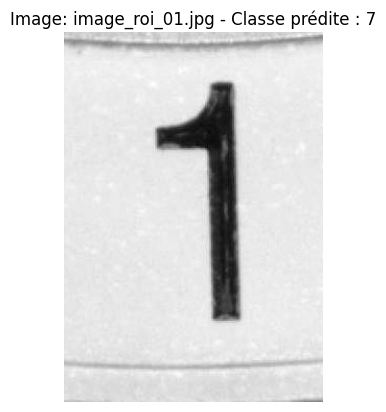

Traitement de l'image : image_roi_02.jpg


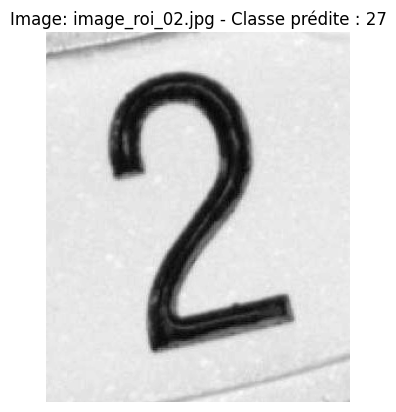

Traitement de l'image : image_roi_03.jpg


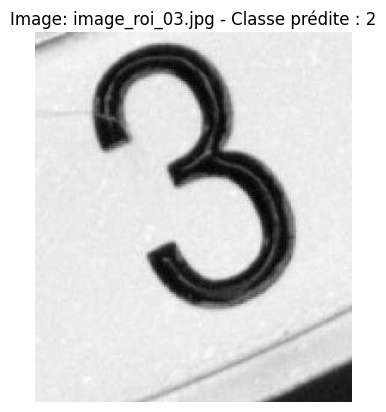

Traitement de l'image : image_roi_04.jpg


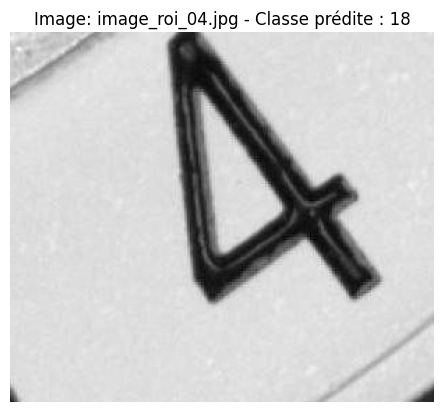

Traitement de l'image : image_roi_05.jpg


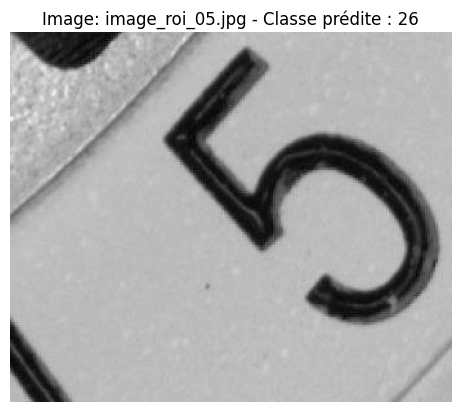

Traitement de l'image : image_roi_06.jpg


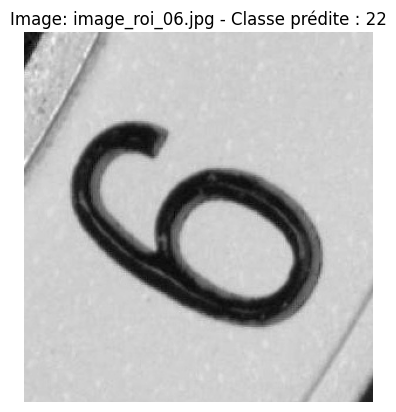

Traitement de l'image : image_roi_07.jpg


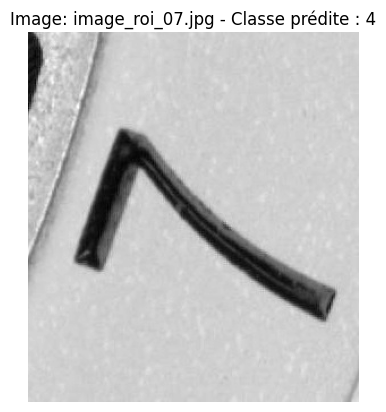

Traitement de l'image : image_roi_08.jpg


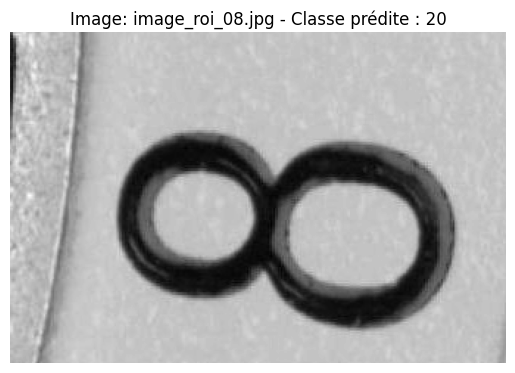

Traitement de l'image : image_roi_09.jpg


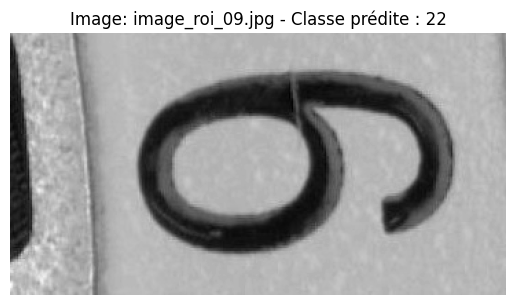

Traitement de l'image : image_roi_10.jpg


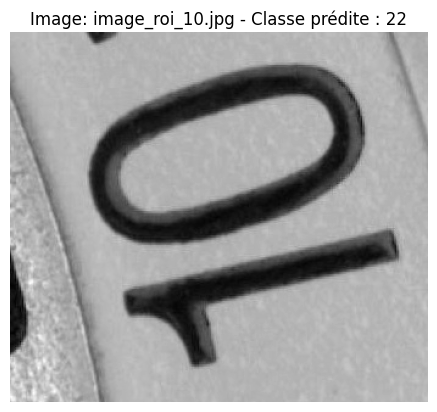

Traitement de l'image : image_roi_11.jpg


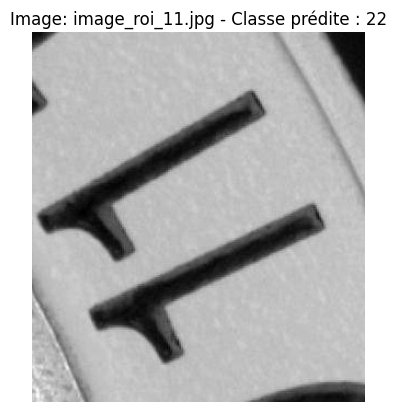

Traitement de l'image : image_roi_12.jpg


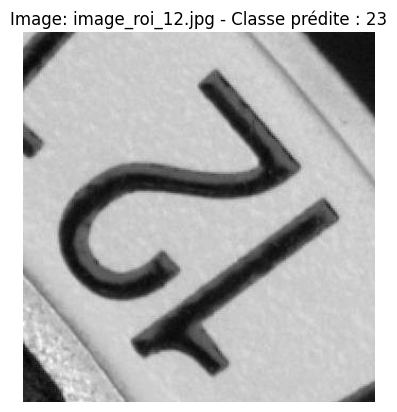

Traitement de l'image : image_roi_13.jpg


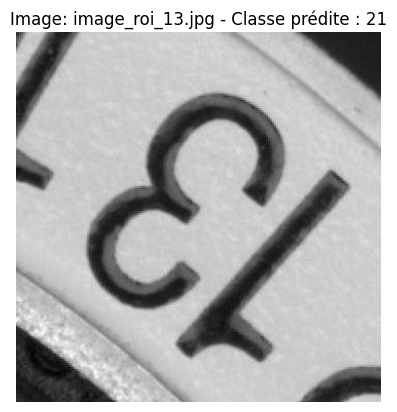

Traitement de l'image : image_roi_14.jpg


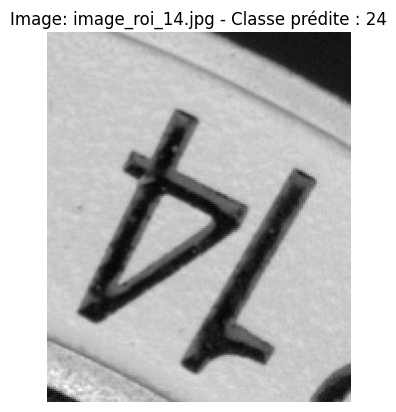

Traitement de l'image : image_roi_15.jpg


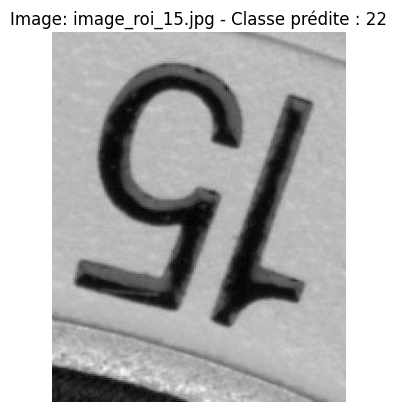

Traitement de l'image : image_roi_16.jpg


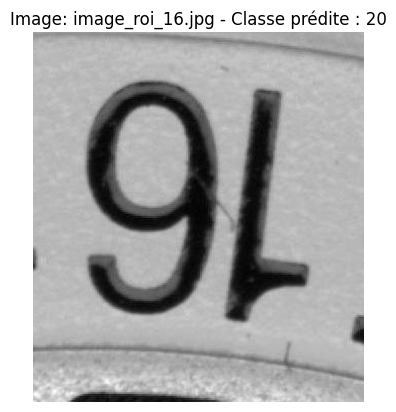

Traitement de l'image : image_roi_17.jpg


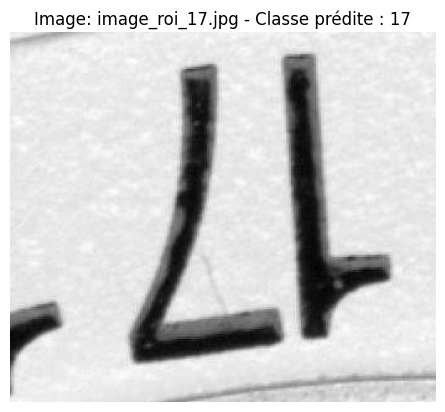

Traitement de l'image : image_roi_18.jpg


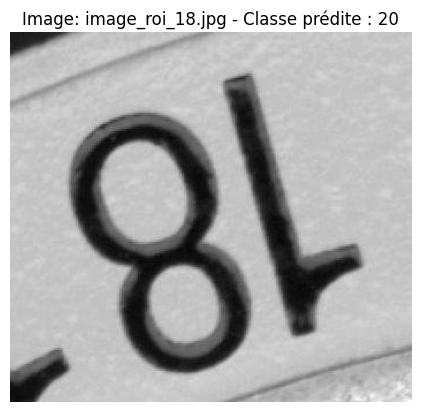

Traitement de l'image : image_roi_19.jpg


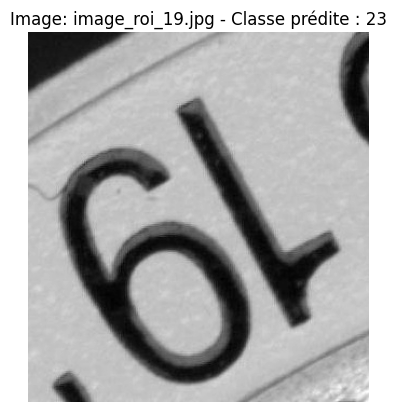

Traitement de l'image : image_roi_20.jpg


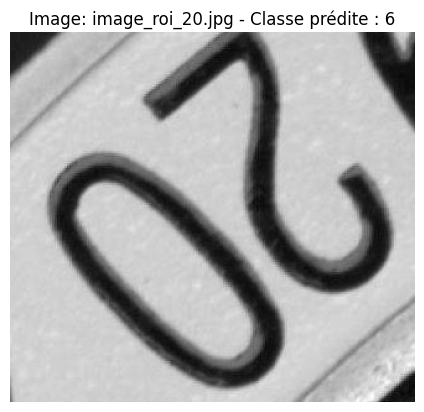

Traitement de l'image : image_roi_21.jpg


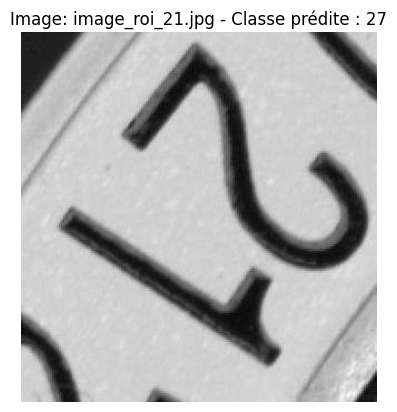

Traitement de l'image : image_roi_22.jpg


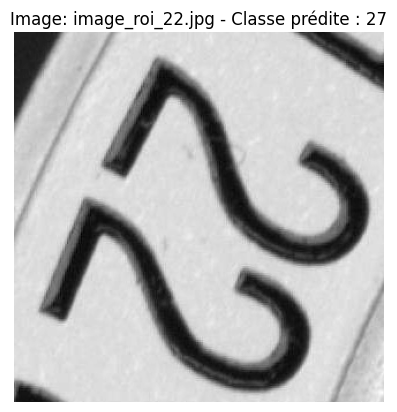

Traitement de l'image : image_roi_23.jpg


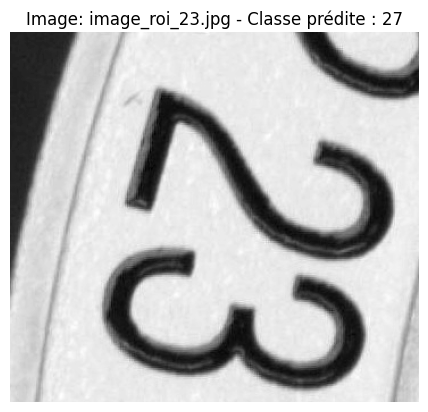

Traitement de l'image : image_roi_24.jpg


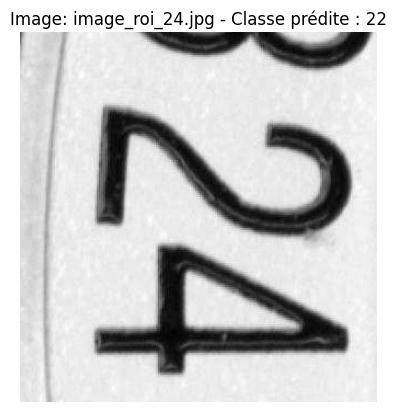

Traitement de l'image : image_roi_25.jpg


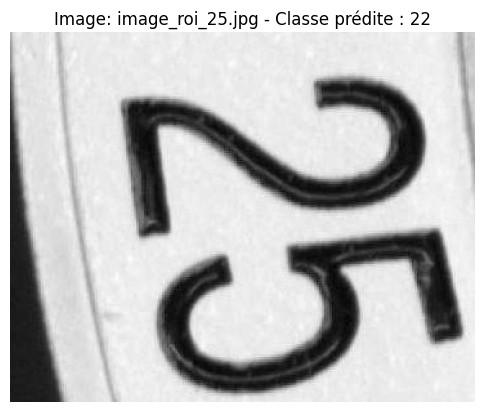

Traitement de l'image : image_roi_26.jpg


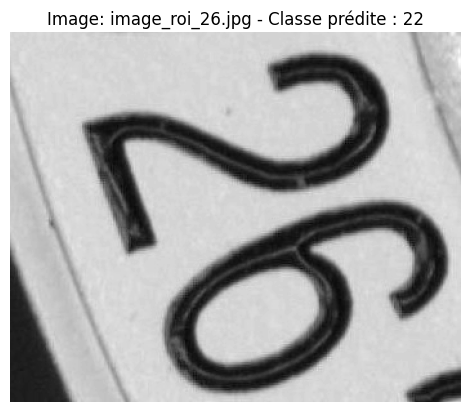

Traitement de l'image : image_roi_27.jpg


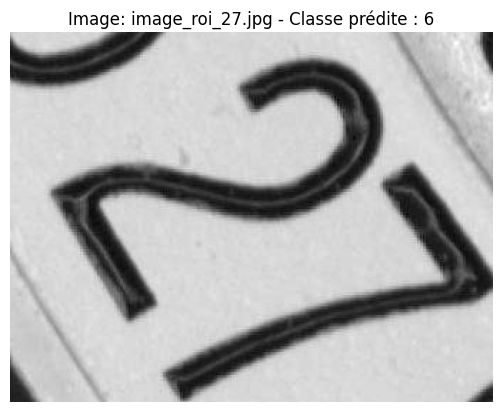

Traitement de l'image : image_roi_28.jpg


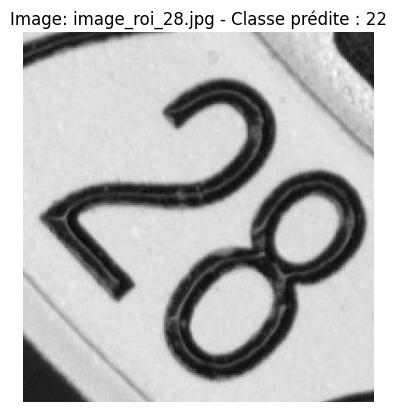

Traitement de l'image : image_roi_29.jpg


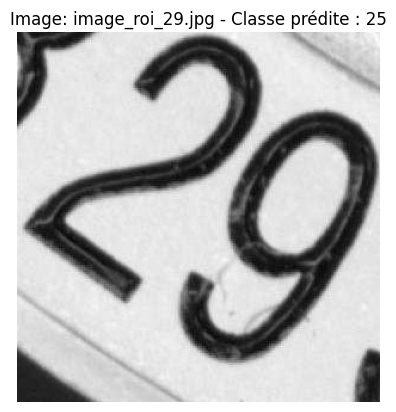

Traitement de l'image : image_roi_30.jpg


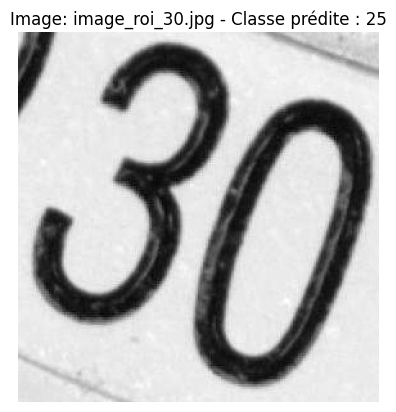

Traitement de l'image : image_roi_31.jpg


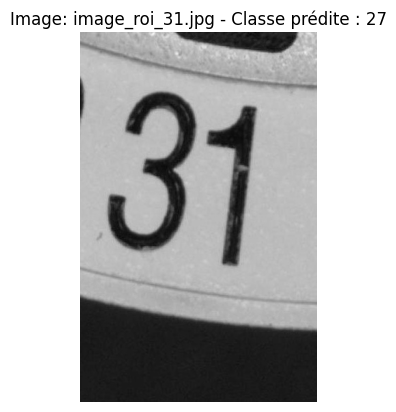


Résumé des prédictions :
Image: image_roi_01.jpg, Classe prédite: 7
Image: image_roi_02.jpg, Classe prédite: 27
Image: image_roi_03.jpg, Classe prédite: 2
Image: image_roi_04.jpg, Classe prédite: 18
Image: image_roi_05.jpg, Classe prédite: 26
Image: image_roi_06.jpg, Classe prédite: 22
Image: image_roi_07.jpg, Classe prédite: 4
Image: image_roi_08.jpg, Classe prédite: 20
Image: image_roi_09.jpg, Classe prédite: 22
Image: image_roi_10.jpg, Classe prédite: 22
Image: image_roi_11.jpg, Classe prédite: 22
Image: image_roi_12.jpg, Classe prédite: 23
Image: image_roi_13.jpg, Classe prédite: 21
Image: image_roi_14.jpg, Classe prédite: 24
Image: image_roi_15.jpg, Classe prédite: 22
Image: image_roi_16.jpg, Classe prédite: 20
Image: image_roi_17.jpg, Classe prédite: 17
Image: image_roi_18.jpg, Classe prédite: 20
Image: image_roi_19.jpg, Classe prédite: 23
Image: image_roi_20.jpg, Classe prédite: 6
Image: image_roi_21.jpg, Classe prédite: 27
Image: image_roi_22.jpg, Classe prédite: 27
Image: ima

In [10]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

def predict_image(image_path_or_pil, model, transform, device):
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil).convert("L")
    else:
        image = image_path_or_pil.convert("L")
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item() + 1  # Revenir à 1–31
    
    plt.imshow(image, cmap="gray")
    plt.title(f"Image: {os.path.basename(image_path_or_pil) if isinstance(image_path_or_pil, str) else 'PIL Image'} - Classe prédite : {predicted_label}")
    plt.axis("off")
    plt.show()
    
    return predicted_label

def predict_images_in_folder(folder_path, model, transform, device):
    # Liste pour stocker les résultats
    predictions = []
    
    # Vérifier si le dossier existe
    if not os.path.exists(folder_path):
        print(f"Erreur : Le dossier {folder_path} n'existe pas.")
        return predictions
    
    # Parcourir toutes les images dans le dossier
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrer les fichiers image
            image_path = os.path.join(folder_path, filename)
            print(f"Traitement de l'image : {filename}")
            
            # Prédire la classe de l'image
            predicted_label = predict_image(image_path, model, transform, device)
            predictions.append((filename, predicted_label))
    
    # Afficher un résumé des prédictions
    print("\nRésumé des prédictions :")
    for filename, label in predictions:
        print(f"Image: {filename}, Classe prédite: {label}")
    
    return predictions

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration du modèle (à adapter selon ton environnement)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Chargement du modèle enregistré
    model = ChiffreCNN().to(device)
    model.load_state_dict(torch.load("best_chiffre_cnn.pth", map_location=device))
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Dossier contenant les images
    folder_path = "extracted_rois"
    
    # Prédire pour toutes les images dans le dossier
    predictions = predict_images_in_folder(folder_path, model, transform, device)